# Projeto: Detecção de Pneumonia via Raios-X de Tórax (CNN)

## Introdução
O objetivo deste projeto é desenvolver um modelo de Deep Learning baseado em Redes Neurais Convolucionais (CNN) para automatizar a detecção de pneumonia em imagens de Raios-X de tórax. O projeto abrange desde a análise exploratória até o deploy em um container Docker.

### Dataset
O conjunto de dados é composto por imagens de Raios-X de tórax (anterior-posterior) selecionadas de coortes retrospectivas de pacientes pediátricos. As imagens são divididas em duas classes: **Normal** e **Pneumonia**.

---

## Análise da Distribuição das Classes
Nesta etapa, verificamos a quantidade de amostras disponíveis em cada conjunto (Treino, Teste e Validação).

In [2]:
import os
import pandas as pd

base_path = '../data'
sets = ['train', 'val', 'test']
categories = ['NORMAL', 'PNEUMONIA']

data = []

for s in sets:
    for cat in categories:
        path = os.path.join(base_path, s, cat)
        count = len(os.listdir(path))
        data.append([s, cat, count])

df_counts = pd.DataFrame(data, columns=['Dataset', 'Classe', 'Total'])
print(df_counts)

# Pivot para melhor visualização
print(df_counts.pivot(index='Dataset', columns='Classe', values='Total'))

  Dataset     Classe  Total
0   train     NORMAL   1342
1   train  PNEUMONIA   3876
2     val     NORMAL      9
3     val  PNEUMONIA      9
4    test     NORMAL    234
5    test  PNEUMONIA    390
Classe   NORMAL  PNEUMONIA
Dataset                   
test        234        390
train      1342       3876
val           9          9


### Observações:
* **Desbalanceamento:** O conjunto de treino apresenta um desbalanceamento significativo (Pneumonia >> Normal).
* **Estratégia:** Durante o treinamento, deveremos considerar o uso de **Pesos de Classe (Class Weights)** ou técnicas de **Data Augmentation** para evitar que o modelo se torne tendencioso para a classe majoritária.

## Visualização de Imagens
Nesta etapa, carregamos amostras aleatórias de pulmões "Normais" e com "Pneumonia".

Amostras de imagens NORMAL:


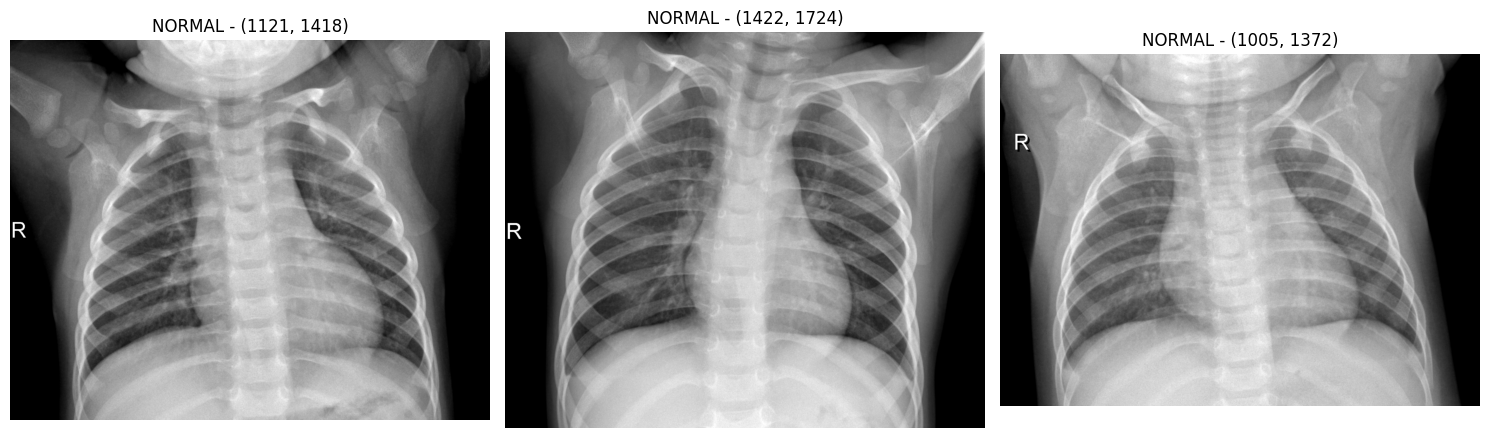

Amostras de imagens PNEUMONIA:


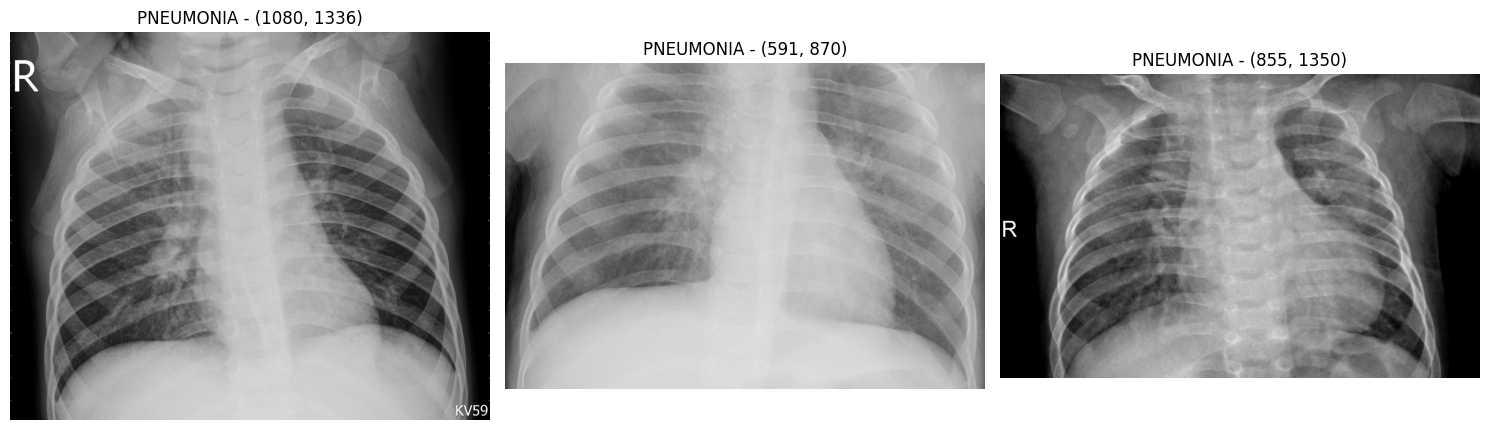

In [4]:
import cv2
import random
import matplotlib.pyplot as plt

def plot_samples(base_path, category):
    folder = os.path.join(base_path, 'train', category)
    img_names = random.sample(os.listdir(folder), 3)

    plt.figure(figsize=(15,5))
    for i, name in enumerate(img_names):
        img_path = os.path.join(folder, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f'{category} - {img.shape[:2]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Amostras de imagens NORMAL:")
plot_samples(base_path, 'NORMAL')

print("Amostras de imagens PNEUMONIA:")
plot_samples(base_path, 'PNEUMONIA')

## Preparação dos Dados (Data Augmentation)
Nesta etapa, padronizamos o tamanho das imagens para **224x224** e aplicamos transformações aleatórias (rotação, zoom, inversão horizontal) no conjunto de treino.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurações globais
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Gerador para treino com Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerador para validação e teste sem Data Augmentation
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Carregando as imagens dos diretórios
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Construção do Modelo
Utilizaremos a arquitetura **MobileNetV2** pré-treinada na ImageNet como base. Congelaremos as camadas iniciais para aproveitar os extratores de características já aprendidos e adicionaremos uma cabeça de classificação customizada para o nosso problema.

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Carregar o modelo pré-treinado MobileNetV2
base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')

# Congelar as camadas do modelo base
base_model.trainable = False

# Construir o modelo completo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)